In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
from datetime import datetime
import os
import statsmodels.api as sm
import seaborn as sns



# Download SGDNEER from MAS Website


In [2]:

download_dir = "/Users/yb/Downloads"  #update dir
options = webdriver.ChromeOptions()
options.add_experimental_option("prefs", {
    "download.default_directory": download_dir,   
    "download.prompt_for_download": False,
    "directory_upgrade": True,
    "safebrowsing.enabled": True
})

#webdriver
service = Service('/Users/yb/Downloads/chromedriver-mac-arm64/chromedriver') #update chrome driver dir
driver = webdriver.Chrome(service=service, options=options)

#mas webpage
driver.get("https://www.mas.gov.sg/statistics/exchange-rates/s$neer")


time.sleep(5)
#click download button
download_button = driver.find_element(By.XPATH, "//*[contains(text(), 'DOWNLOAD')]")
download_button.click()
time.sleep(10)
driver.quit()



In [3]:
#retrieve downloaded file
downloaded_files = os.listdir(download_dir)
downloaded_file = max([os.path.join(download_dir, f) for f in downloaded_files], key=os.path.getctime)
df = pd.read_excel(downloaded_file)
df['Average for Week Ending'] = pd.to_datetime(df['Average for Week Ending'])


#start frrom 2022-01-03
start_date = datetime(2022, 1, 3)
df = df[df['Average for Week Ending'] >= start_date]
#df['Average for Week Ending'] =df['Average for Week Ending'] .dt.date
df['Average for Week Ending'] = pd.to_datetime(df['Average for Week Ending']).dt.date
df['Average for Week Ending'] = pd.to_datetime(df['Average for Week Ending']).dt.normalize()
df.rename(columns={'Index (Year 1999=100)': "Official"},inplace = True)
df.head()


,Average for Week Ending,Official
0,2024-12-27,139.06
1,2024-12-20,139.00
2,2024-12-13,139.10
3,2024-12-06,138.93
4,2024-11-29,138.94


# Import Citi and GS index and rearrange to weekly data

In [4]:
custom= pd.read_excel("sgdneer.xlsx")
custom['Date'] = pd.to_datetime(custom['Date'])
custom.set_index('Date', inplace=True)

#Resample to weekly 
weekly_avg = custom.resample('W-FRI').mean().reset_index()
weekly_avg.columns = ['Average for Week Ending', 'CTSGSGD','GSSGSGD']
weekly_avg['Average for Week Ending'] = pd.to_datetime(weekly_avg['Average for Week Ending']).dt.normalize()
weekly_avg[['CTSGSGD','GSSGSGD']]=weekly_avg[['CTSGSGD','GSSGSGD']].round(2)

weekly_avg


,Average for Week Ending,CTSGSGD,GSSGSGD
0,2022-05-06,129.42,129.37
1,2022-05-13,129.43,129.38
2,2022-05-20,129.69,129.57
3,2022-05-27,130.08,129.90
4,2022-06-03,130.00,129.81
...,...,...,...
135,2024-12-06,139.03,138.94
136,2024-12-13,139.15,139.01
137,2024-12-20,138.92,138.76
138,2024-12-27,139.05,138.94


In [5]:
merged = pd.merge(df,weekly_avg, on = "Average for Week Ending",how ='left')
merged

,Average for Week Ending,Official,CTSGSGD,GSSGSGD
0,2024-12-27,139.06,139.05,138.94
1,2024-12-20,139.00,138.92,138.76
2,2024-12-13,139.10,139.15,139.01
3,2024-12-06,138.93,139.03,138.94
4,2024-11-29,138.94,138.87,138.89
...,...,...,...,...
151,2022-02-04,127.42,NaN,NaN
152,2022-01-28,127.47,NaN,NaN
153,2022-01-21,127.05,NaN,NaN
154,2022-01-14,126.88,NaN,NaN


In [190]:
merged.to_excel("df.xlsx",index = False)

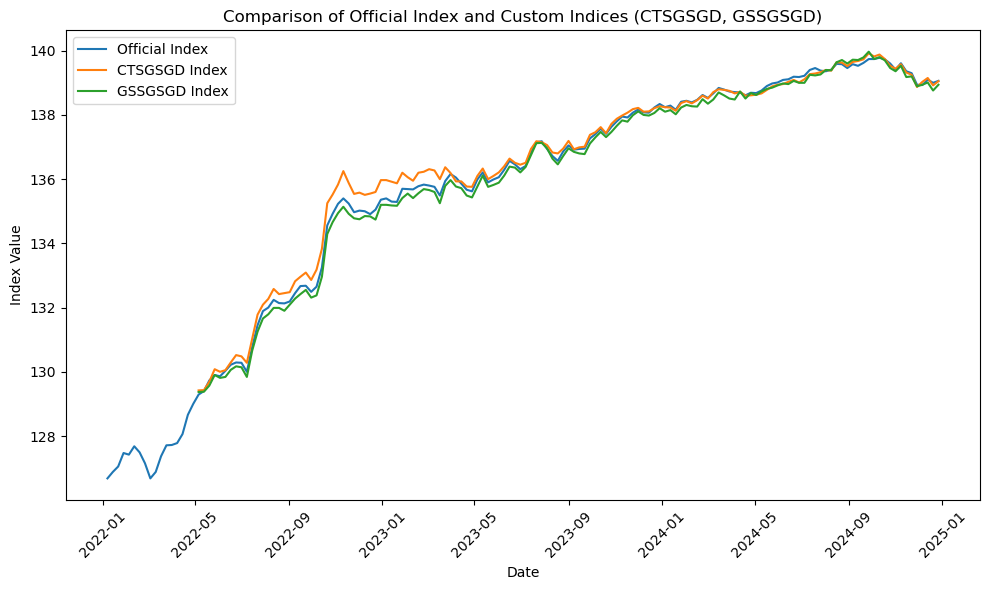

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(merged['Average for Week Ending'], merged['Official'], label='Official Index', linestyle='-',)
plt.plot(merged['Average for Week Ending'], merged['CTSGSGD'], label='CTSGSGD Index', linestyle='-'  )
plt.plot(merged['Average for Week Ending'], merged['GSSGSGD'], label='GSSGSGD Index', linestyle='-' )

plt.title('Comparison of Official Index and Custom Indices (CTSGSGD, GSSGSGD)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
merged = merged.dropna()
merged_df = merged.copy()
merged_df

,Average for Week Ending,Official,CTSGSGD,GSSGSGD
0,2024-12-27,139.06,139.05,138.94
1,2024-12-20,139.00,138.92,138.76
2,2024-12-13,139.10,139.15,139.01
3,2024-12-06,138.93,139.03,138.94
4,2024-11-29,138.94,138.87,138.89
...,...,...,...,...
134,2022-06-03,129.86,130.00,129.81
135,2022-05-27,129.90,130.08,129.90
136,2022-05-20,129.73,129.69,129.57
137,2022-05-13,129.40,129.43,129.38


Tracking Error (CTSGSGD vs Official): 0.000632
Tracking Error (GSSGSGD vs Official): 0.000578


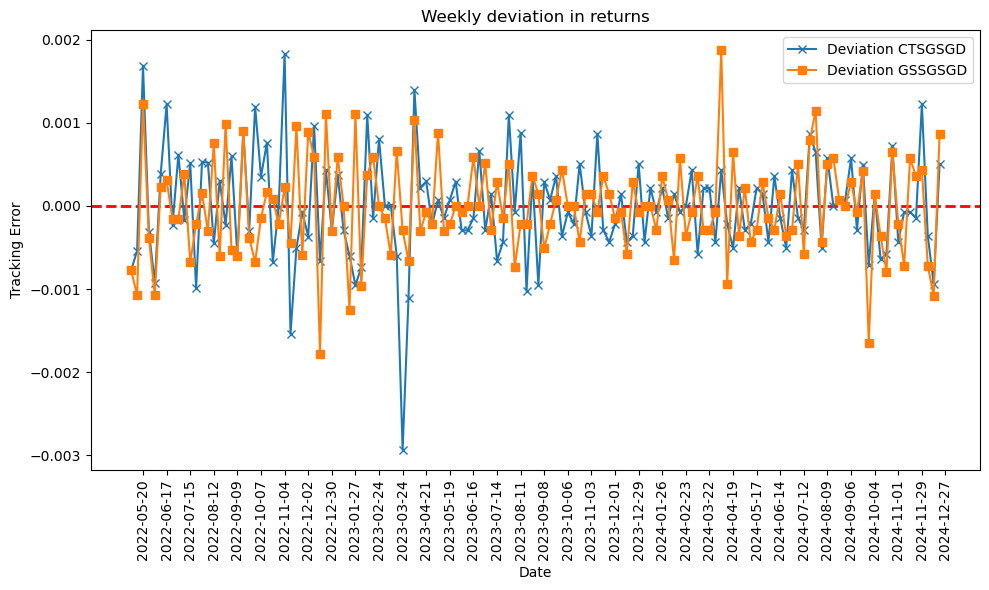

In [8]:
#Tacking error for CTSGSGD and GSSGSGD
merged = merged.dropna()

#return
merged['Official Return'] =merged['Official'].pct_change()
merged['CTSGSGD Return'] = merged['CTSGSGD'].pct_change()
merged['GSSGSGD Return'] =merged['GSSGSGD'].pct_change()

merged['Deviation CTSGSGD'] = merged['Official Return'] - merged['CTSGSGD Return']
merged['Deviation GSSGSGD'] = merged['Official Return'] - merged['GSSGSGD Return']

merged_clean = merged.dropna(subset=['Deviation CTSGSGD', 'Deviation GSSGSGD'])

#standard deviation (tracking error)
tracking_error_cts = np.std(merged_clean['Deviation CTSGSGD'])
tracking_error_gss = np.std(merged_clean['Deviation GSSGSGD'])

print(f"Tracking Error (CTSGSGD vs Official): {tracking_error_cts:.6f}")
print(f"Tracking Error (GSSGSGD vs Official): {tracking_error_gss:.6f}")


plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='red', linewidth=2, linestyle='--')  # Dashed red line
plt.plot(merged_clean['Average for Week Ending'], merged_clean['Deviation CTSGSGD'], label='Deviation CTSGSGD', linestyle='-', marker='x')
plt.plot(merged_clean['Average for Week Ending'], merged_clean['Deviation GSSGSGD'], label='Deviation GSSGSGD', linestyle='-', marker='s')


plt.title('Weekly deviation in returns')
plt.xlabel('Date')

plt.ylabel('Tracking Error')
plt.legend(loc='best')

plt.xticks(
    ticks=merged['Average for Week Ending'][::4],  # Set tick frequency (every 4th date, adjust as needed)
    labels=merged['Average for Week Ending'][::4].dt.strftime('%Y-%m-%d'),  # Format labels as 'YYYY-MM-DD'
    rotation=90   
)
plt.tight_layout()


plt.show()


# Major currency affecting SGD exchange rate

In [9]:

#LIst of most important currencies against SGD
currencies = [
    'SGD=X',       
    'EURSGD=X',    
    'SGDJPY=X',   
    'SGDCNY=X',    
    'MYR=X',    
    'SGDTHB=X',    
    'AUDSGD=X',    
    'SGDIDR=X',    
    'KRWSGD=X',    
    'TWDSGD=X',      
    'SGDINR=X',    
    'HKDSGD=X',    
    'GBPSGD=X',     
    'PHP=X'   
]

data = yf.download(currencies, start="2022-01-03", end="2025-01-01", actions=False)['Adj Close']


currency_data = pd.DataFrame()
#convert all currency to format: USD/SGD
currency_data['USD'] = data['SGD=X']
currency_data['EUR']= data['EURSGD=X'] 
currency_data['JPY'] = 1/data['SGDJPY=X'] 
currency_data['CNY'] = 1/data['SGDCNY=X'] 
currency_data['MYR'] = data['MYR=X']  / data['SGD=X'] 
currency_data['THB'] = 1/data['SGDTHB=X'] 
currency_data['AUD'] = data['AUDSGD=X']
currency_data['IDR'] = 1/data['SGDIDR=X'] 
currency_data['KRW']= data['KRWSGD=X']
currency_data['HKD']= data['HKDSGD=X']
currency_data['TWD']= data['TWDSGD=X']
currency_data['INR'] = 1/data['SGDINR=X']
currency_data['GBP']= data['GBPSGD=X']
currency_data['PHP']=data['PHP=X']  / data['SGD=X'] 

currency_data

[*********************100%***********************]  14 of 14 completed


,USD,EUR,JPY,CNY,MYR,THB,AUD,IDR,KRW,HKD,TWD,INR,GBP,PHP
Date,,,,,,,,,,,,,,
2022-01-03 00:00:00+00:00,1.34820,1.53323,0.011711,0.212487,3.096722,0.040668,0.97978,0.000095,0.001134,0.172926,0.048644,0.018118,1.82289,37.730362
2022-01-04 00:00:00+00:00,1.35312,1.52927,0.011733,0.213228,3.081767,0.040755,0.97320,0.000095,0.001134,0.173513,0.048956,0.018204,1.82428,37.997371
2022-01-05 00:00:00+00:00,1.35571,1.52910,0.011671,0.213019,3.086206,0.040830,0.98090,0.000094,0.001132,0.173942,0.049347,0.018208,1.83330,38.042796
2022-01-06 00:00:00+00:00,1.35771,1.53510,0.011693,0.213624,3.087552,0.040887,0.97990,0.000094,0.001131,0.174106,0.049154,0.018295,1.84023,37.482231
2022-01-07 00:00:00+00:00,1.36094,1.53713,0.011747,0.213549,3.094185,0.040594,0.97440,0.000094,0.001129,0.174453,0.049253,0.018314,1.84166,37.892927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25 00:00:00+00:00,1.35980,1.41490,0.008656,0.186535,3.297911,0.039908,0.84810,0.000085,0.000938,0.175090,0.041651,0.015984,1.70320,41.992942
2024-12-26 00:00:00+00:00,1.35898,1.41301,0.008649,0.186247,3.299901,0.039679,0.84835,0.000085,0.000937,0.174958,0.041525,0.015978,1.70452,42.679070
2024-12-27 00:00:00+00:00,1.35878,1.41615,0.008615,0.186214,3.287140,0.039882,0.84547,0.000084,0.000939,0.174928,0.041509,0.016000,1.70220,42.661798


In [10]:
#resample to weekly
currency_returns = currency_data.pct_change().dropna()
currency_returns_weekly = currency_returns.resample('W-FRI').mean()
currency_returns_weekly = currency_returns_weekly.reset_index()

currency_returns_weekly = currency_returns_weekly.rename(columns={'Date': 'Week Ending'})


currency_returns_weekly['Week Ending'] = currency_returns_weekly['Week Ending'].dt.tz_localize(None)


currency_merged = pd.merge(merged, currency_returns_weekly, 
                            left_on='Average for Week Ending', 
                            right_on='Week Ending', 
                            how='left').dropna()


print(currency_merged)


    Average for Week Ending  Official  CTSGSGD  GSSGSGD  Official Return  \
1                2024-12-20    139.00   138.92   138.76        -0.000431   
2                2024-12-13    139.10   139.15   139.01         0.000719   
3                2024-12-06    138.93   139.03   138.94        -0.001222   
4                2024-11-29    138.94   138.87   138.89         0.000072   
5                2024-11-22    139.30   139.25   139.20         0.002591   
..                      ...       ...      ...      ...              ...   
134              2022-06-03    129.86   130.00   129.81        -0.001307   
135              2022-05-27    129.90   130.08   129.90         0.000308   
136              2022-05-20    129.73   129.69   129.57        -0.001309   
137              2022-05-13    129.40   129.43   129.38        -0.002544   
138              2022-05-06    129.29   129.42   129.37        -0.000850   

     CTSGSGD Return  GSSGSGD Return  Deviation CTSGSGD  Deviation GSSGSGD  \
1         

In [153]:
currency_merged.to_excel('currency_merged.xlsx', index=False)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File ~/anaconda3/lib/python3.10/site-packages/pandas/core/indexes/base.py:3802, in Index.get_loc(
    self=Index(['Average for Week Ending', 'Official'], dtype='object'),
    key='Category',
    method=None,
    tolerance=None
)
   3801 try:
-> 3802     return self._engine.get_loc(casted_key)
        casted_key = 'Category'
        self = Index(['Average for Week Ending', 'Official'], dtype='object')
   3803 except KeyError as err:

File ~/anaconda3/lib/python3.10/site-packages/pandas/_libs/index.pyx:138, in pandas._libs.index.IndexEngine.get_loc()

File ~/anaconda3/lib/python3.10/site-packages/pandas/_libs/index.pyx:165, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:5745, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:5753, in pandas._libs

# OLS regression
Since either of the weightage of the index is known, OLS may be helpful to identify ff there are weighting differences of the difference currencies, the two indices might behave differently in response to currency fluctuations. This regression might help identify if currency returns are a key factor in explaining those differences. If one index is more sensitive to a specific currency, the coefficient for that currency may be larger or more significant in the regression.

In [11]:

X = currency_merged[['USD', 'EUR', 'JPY', 'CNY','MYR','IDR','PHP']]
X = sm.add_constant(X) 
y = currency_merged['Deviation CTSGSGD']  


model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Deviation CTSGSGD   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2.882
Date:                Tue, 07 Jan 2025   Prob (F-statistic):            0.00785
Time:                        22:55:49   Log-Likelihood:                 830.76
No. Observations:                 138   AIC:                            -1646.
Df Residuals:                     130   BIC:                            -1622.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.174e-06   5.36e-05      0.171      0.8

In [12]:
#GS SGD
y = currency_merged['Deviation GSSGSGD'] # Dependent variable (deviation)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Deviation GSSGSGD   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.391
Date:                Tue, 07 Jan 2025   Prob (F-statistic):              0.214
Time:                        22:55:52   Log-Likelihood:                 837.99
No. Observations:                 138   AIC:                            -1660.
Df Residuals:                     130   BIC:                            -1637.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.953e-06   5.08e-05     -0.156      0.8

In [13]:
#only regress during May 2022 to Dec 2022



currency_merged['Average for Week Ending'] = pd.to_datetime(currency_merged['Average for Week Ending'])


start_date = '2022-05-01'
end_date = '2022-12-07'


filtered_data = currency_merged[(currency_merged['Average for Week Ending'] >= start_date) & 
                                 (currency_merged['Average for Week Ending'] <= end_date)]


X = filtered_data[['USD', 'EUR', 'JPY', 'CNY','MYR','IDR','PHP']]
#['USD', 'EUR', 'JPY', 'CNY', 'MYR', 'THB', 'AUD', 'IDR', 'KRW', 'HKD','TWD', 'INR', 'GBP', 'PHP']]
#THB, AUD, KRW,HKD,TWD,INR,GBP
X = sm.add_constant(X)   

y = filtered_data['Deviation GSSGSGD']

 
model = sm.OLS(y, X).fit()

 
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Deviation GSSGSGD   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.8620
Date:                Tue, 07 Jan 2025   Prob (F-statistic):              0.550
Time:                        22:55:55   Log-Likelihood:                 188.67
No. Observations:                  31   AIC:                            -361.3
Df Residuals:                      23   BIC:                            -349.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.752      0.4

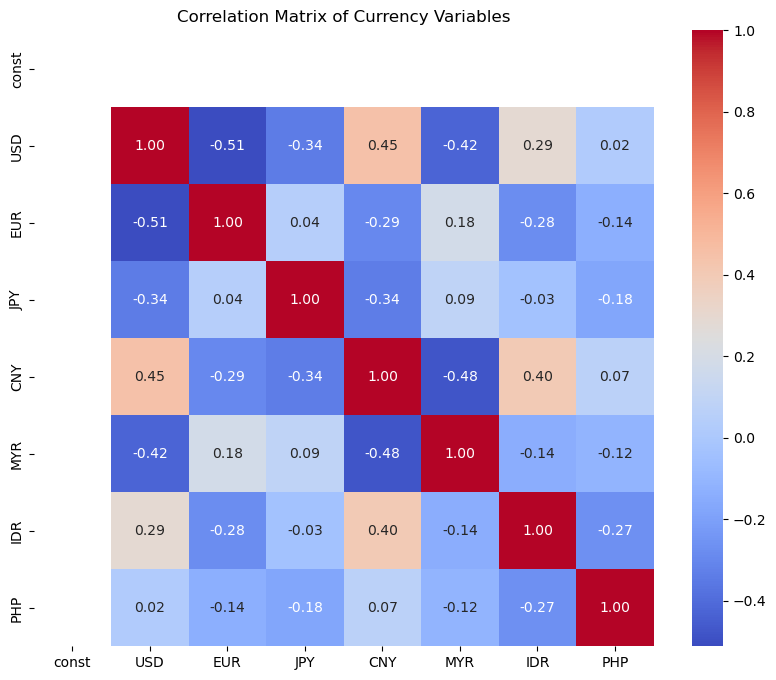

In [14]:
#calculate corr to avoid multicollinearity
correlation_matrix = X.corr()

# removed THB, AUD, KRW,HKD,TWD,INR
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, 
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

 
plt.title("Correlation Matrix of Currency Variables")
plt.show()